# Demo for Localization Overlap between Neutrinos and AGN

In [1]:
# imports:
from astropy.coordinates import SkyCoord, Galactic, ICRS, FK5
from ligo.skymap.postprocess import crossmatch
from astropy.table import Column, Table, join
from ligo.skymap.io import read_sky_map
from matplotlib import pyplot as plt
from astropy_healpix import HEALPix
import astropy.coordinates as coord
from astropy import units as u
from astropy.io import fits
import ligo.skymap.plot
import ligo.skymap.moc
import healpy as hp
import numpy as np
import scipy
import math
%matplotlib inline

In [2]:
# opening BBH LIGO data:
S190521g = '../SCiMMA_Project/bayestar..fits' 
bbh_data = Table.read(S190521g)
bbh_data['UNIQ'].dtype = 'int64'

bbh_data

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
1024,8.562923598145879e-16,-73.1221838420601,404.8957816151533,1.642233920921469e-05
1025,4.176516357354336e-15,68.2374584111227,332.64745440105355,1.3176395652839827e-05
1026,3.198966440941042e-15,inf,1.0,0.0
1027,1.612168462253233e-14,inf,1.0,0.0
1028,3.450109291678728e-14,256.0997941341065,243.56971234063764,8.269385576697428e-06
1029,6.756908863812749e-13,326.2571814117856,178.36016600808077,7.248683126963574e-06
1030,8.637860183879541e-14,inf,1.0,0.0
1031,7.210172950103072e-13,-1186.8294485230274,468.51114235164437,0.004246181769654647


In [3]:
# Converting UNIQ to NESTED Ordering
bbh_data_nested = Table(ligo.skymap.moc.rasterize(bbh_data))

bbh_data_nested['PROBDENSITY']

8.562923598145879e-16
8.562923598145879e-16
8.562923598145879e-16
8.562923598145879e-16
8.562923598145879e-16
8.562923598145879e-16
8.562923598145879e-16
8.562923598145879e-16
8.562923598145879e-16
8.562923598145879e-16
8.562923598145879e-16


In [4]:
# adding an index row to prevent pixel scrambling:
index = Column(np.arange(len(bbh_data_nested['PROBDENSITY'])), name='INDEX')
bbh_data_nested.add_column(index, index=0)

# creating new prob per pixel column to later ID 90% prob area:
pixprob = Column(bbh_data_nested['PROBDENSITY']*4*math.pi/len(bbh_data_nested['PROBDENSITY']), name='PIXELPROB')
bbh_data_nested.add_column(pixprob)

bbh_data_nested

INDEX,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PIXELPROB
int64,float64,float64,float64,float64,float64
0,8.562923598145879e-16,-73.1221838420601,404.8957816151533,1.642233920921469e-05,3.420666741585512e-21
1,8.562923598145879e-16,-73.1221838420601,404.8957816151533,1.642233920921469e-05,3.420666741585512e-21
2,8.562923598145879e-16,-73.1221838420601,404.8957816151533,1.642233920921469e-05,3.420666741585512e-21
3,8.562923598145879e-16,-73.1221838420601,404.8957816151533,1.642233920921469e-05,3.420666741585512e-21
4,8.562923598145879e-16,-73.1221838420601,404.8957816151533,1.642233920921469e-05,3.420666741585512e-21
5,8.562923598145879e-16,-73.1221838420601,404.8957816151533,1.642233920921469e-05,3.420666741585512e-21
6,8.562923598145879e-16,-73.1221838420601,404.8957816151533,1.642233920921469e-05,3.420666741585512e-21
7,8.562923598145879e-16,-73.1221838420601,404.8957816151533,1.642233920921469e-05,3.420666741585512e-21
8,8.562923598145879e-16,-73.1221838420601,404.8957816151533,1.642233920921469e-05,3.420666741585512e-21


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


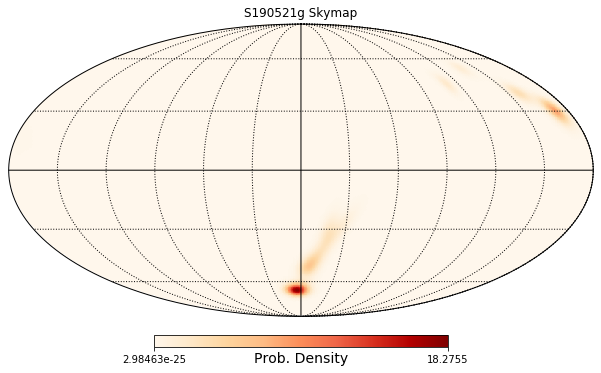

In [5]:
hp.mollview(bbh_data_nested['PROBDENSITY'], nest=True, cmap='OrRd', title='S190521g Skymap', unit='Prob. Density')
hp.graticule()

<IPython.core.display.Javascript object>


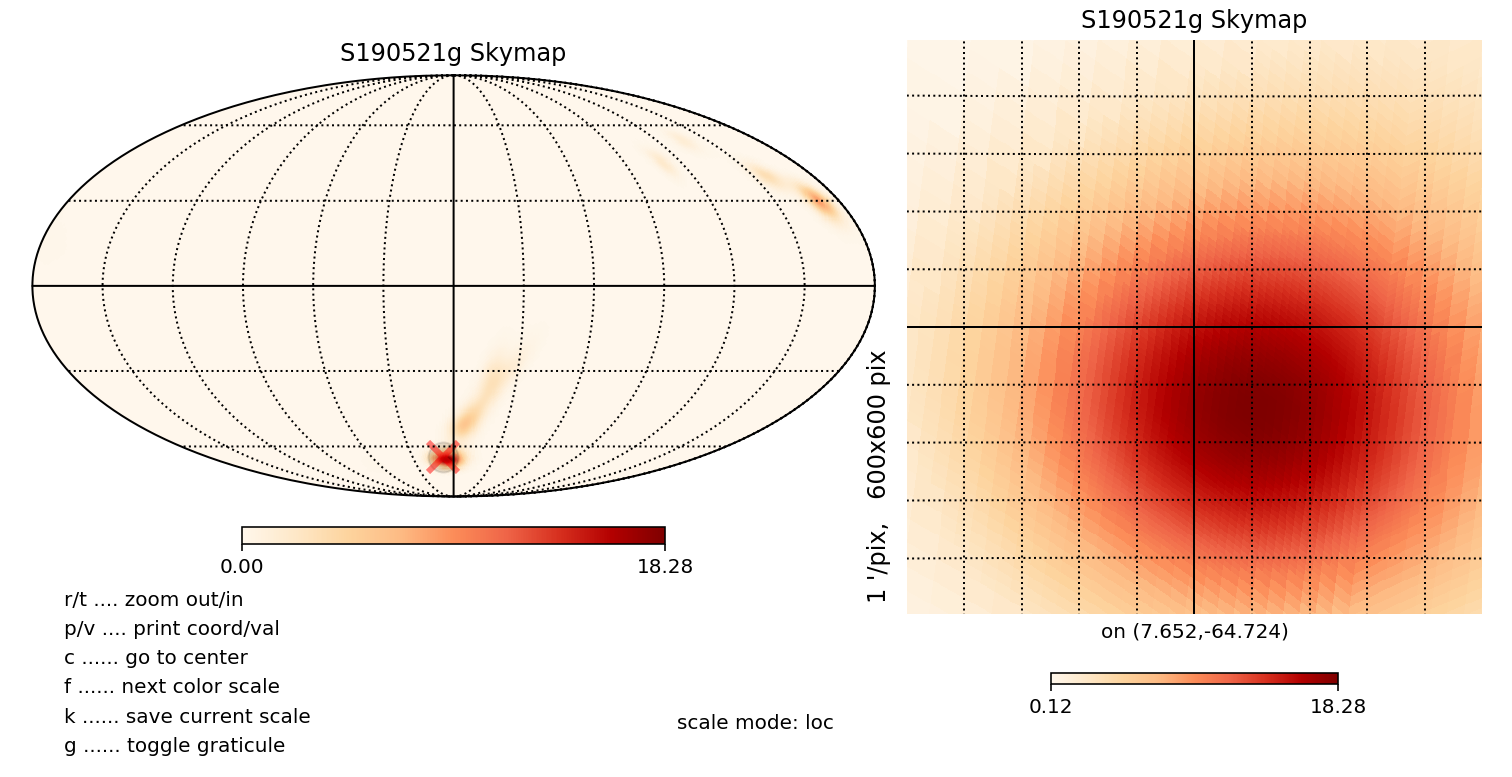

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
82.976115752711 97.023884247289 -7.023884247289008 7.023884247289008
The interval between parallels is 1 deg 0.00'.
The interval between meridians is 1 deg 0.00'.


In [9]:
%matplotlib notebook
hp.mollzoom(bbh_data_nested['PROBDENSITY'], nest=True, cmap='OrRd', title='S190521g Skymap')
hp.graticule()

## General Resources:

1. [HEALPy Documentation](https://healpy.readthedocs.io/en/latest/)
2. [GraceDB](https://gracedb.ligo.org/superevents/public/O3/)
3. [GWOSC](https://www.gw-openscience.org/about/)
https://gcn.gsfc.nasa.gov/fermi_gbm_subthresh_archive.html